In [1]:
%matplotlib inline


import os, sys, pathlib
from pprint import pprint
import gc
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
warnings.simplefilter("ignore")

from IPython.display import display, clear_output

import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
from matplotlib.collections import LineCollection
from tqdm import tqdm


import pyaldata as pyal

if "__file__" not in dir():
    try:
        NB_Path = pathlib.Path.cwd()
        RepoPath = NB_Path.parent
        os.chdir(RepoPath)

        from tools import utilityTools as utility
        from tools import dataTools as dt
        from tools import lstm
        import params
        monkey_defs = params.monkey_defs
        defs = monkey_defs

        set_rc =  params.set_rc_params
        set_rc()
        root = params.root

        os.chdir(RepoPath / 'monkey')
        %run "_dataset-selection.ipynb"
        reload(dt)
        reload(defs)
        reload(lstm)
        reload(params)

        
    finally:
        os.chdir(NB_Path)
    
    
    # %run "S4-decode-example.ipynb"
    
    print('Done!')

FIGPATH = params.figPath / 'figS5-decoding'
if not os.path.exists(FIGPATH):
    os.makedirs(FIGPATH)

Done!


### Get data

In [2]:
full_list = []
for animal, sessionList in GoodDataList[defs.areas[2]].items():
    if 'Mr' in animal:
        continue  # to remove MrT
    full_list.append((animal,sessionList))
full_list = [(animal,session) for animal,sessions in full_list for session in set(sessions)]

# load the DFs
warnings.filterwarnings("ignore")
allDFs = []
for animal, session in full_list:
    path = root/animal/session
    allDFs.append(defs.prep_general(dt.load_pyal_data(path)))
warnings.filterwarnings("default")

#### Fig S5A: Decoding example

In [3]:
def get_ex_data():
    warnings.filterwarnings("ignore")
    raster_example = monkey_defs.raster_example
    raster_example_df = []
    for session in raster_example:
        path = root/session.split('_')[0]/session
        df = monkey_defs.prep_general(dt.load_pyal_data(path))
        # df = pyal.restrict_to_interval(df, epoch_fun=monkey_defs.exec_epoch)
        raster_example_df.append(df)
    warnings.filterwarnings("default")
    return raster_example_df

In [4]:
def _decode_score_and_traj(pairDF):    
    AllData, AllVel = defs.get_data_array_and_vel(pairDF, defs.exec_epoch_decode,
                                                  area=defs.areas[2], n_components=defs.n_components)
    
    # adding history
    AllData = dt.add_history_to_data_array(AllData, defs.MAX_HISTORY)
    AllData = AllData[...,defs.MAX_HISTORY:,:]
    AllVel = AllVel[...,defs.MAX_HISTORY:,:]

    AllData1 = AllData[1,...]
    AllData2 = AllData[0,...]
    AllVel1 = AllVel[1,...]
    AllVel2 = AllVel[0,...]
    # resizing
    n_target,n_trial,n_time,n_comp = AllData1.shape
    X1 = AllData1.reshape((-1,n_comp))
    X2 = AllData2.reshape((-1,n_comp))
    AllVel1 = AllVel1.reshape((-1,n_time,2))
    AllVel2 = AllVel2.reshape((-1,n_time,2))

    orig_data = AllVel2.reshape(n_target, n_trial, n_time, 2)

   
    #aligned
    *_,U,V = dt.canoncorr(X1, X2, fullReturn=True)
    U = U.reshape((-1,n_time,n_comp))
    V = V.reshape((-1,n_time,n_comp))
    lstm_model = lstm.LSTMDecoder(input_dims=U.shape[-1], output_dims=2)
    lstm_model.fit(x_train=U, y_train=AllVel1)
    pred, label = lstm_model.predict(V, AllVel2)
    a_scores = lstm_model.score.mean()
    a_data = (pred[:,0].reshape(n_target, n_trial, n_time),
              pred[:,1].reshape(n_target, n_trial, n_time))
   
    #unaligned
    U, V = X1, X2
    U = U.reshape((-1,n_time,n_comp))
    V = V.reshape((-1,n_time,n_comp))
    lstm_model = lstm.LSTMDecoder(input_dims=U.shape[-1], output_dims=2)
    lstm_model.fit(x_train=U, y_train=AllVel1)
    pred, label = lstm_model.predict(V, AllVel2)
    u_scores = lstm_model.score.mean()
    u_data = (pred[:,0].reshape(n_target, n_trial, n_time),
              pred[:,1].reshape(n_target, n_trial, n_time))
    
    #Within
    X1 = AllData1.reshape((-1,n_time,n_comp))

    reg_scores_ = []
    kf = KFold(n_splits=10)
    for train_index, test_index in kf.split(X1[:,0,0]):
        x_train, x_test = X1[train_index,...], X1[test_index,...]
        y_train, y_test = AllVel1[train_index,...], AllVel1[test_index,...]

        lstm_model = lstm.LSTMDecoder(input_dims=X1.shape[-1], output_dims=2)
        lstm_model.fit(x_train=x_train, y_train=y_train)
        pred, label = lstm_model.predict(x_test, y_test)
        reg_scores_.append(lstm_model.score.mean())
    w_scores = np.mean(reg_scores_)

    lstm_model = lstm.LSTMDecoder(input_dims=X1.shape[-1], output_dims=2)
    lstm_model.fit(x_train=X1, y_train=AllVel1)
    pred, label = lstm_model.predict(X1, AllVel1)
    w_data = (pred[:,0].reshape(n_target, n_trial, n_time),
              pred[:,1].reshape(n_target, n_trial, n_time))

    return n_target, n_trial, n_time, orig_data, w_data, a_data, u_data, w_scores, a_scores, u_scores

In [5]:
def plot_decoding_ex(fig, gs, trial_n = 5):

    allDFs = get_ex_data()
    *_, orig_data, w_data, a_data, u_data, w_scores, a_scores, u_scores = _decode_score_and_traj (allDFs)

    
    axes = []
    for i in range(defs.n_targets):
        axx = fig.add_subplot(gs[0,i])
        axy = fig.add_subplot(gs[1,i])
        axes.append((axx, axy))
        utility.phantom_axes(axx)
        utility.phantom_axes(axy)

        axx.plot(orig_data[i,trial_n,:,0], color='k', label='Actual')
        axy.plot(orig_data[i,trial_n,:,1], color='k', label='Actual')

        axx.plot(w_data[0][i,trial_n,:], color='b', label=fr'Within ($R^2={w_scores:0.2f}$)')
        axy.plot(w_data[1][i,trial_n,:], color='b', label='Within')

        axx.plot(a_data[0][i,trial_n,:], color='r', label=fr'Aligned ($R^2={a_scores:0.2f}$)')
        axy.plot(a_data[1][i,trial_n,:], color='r', label='Aligned')

        axx.plot(u_data[0][i,trial_n,:], color='g', label=fr'Unaligned ($R^2={u_scores:0.2f}$)')
        axy.plot(u_data[1][i,trial_n,:], color='g', label='Unaligned')

        axx.set_title(r'$ \rightarrow $', rotation=(360/monkey_defs.n_targets)*(i-3), pad=0.5)

    axx.legend(ncol=4, loc='center',bbox_to_anchor=(.5,.5), bbox_transform=fig.transFigure)
    
    return np.array(axes).T

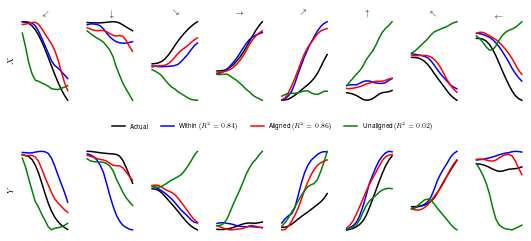

In [6]:
figsize= (params.LargeFig[0],params.panels.BigH)
fig=plt.figure(figsize=figsize)

gs1   =fig.add_gridspec(nrows=2, ncols=defs.n_targets,
                        left=0,  # .7" offset
                        right=1,
                        bottom=0,
                        top=1,
                        wspace=0.3, hspace = .5)

    
axes1 = plot_decoding_ex(fig, gs1, trial_n = 9)
axes1[0,0].set_ylabel('$X$')
axes1[1,0].set_ylabel('$Y$')

fig.savefig(FIGPATH/ 'decoding-example.pdf', format='pdf', bbox_inches='tight')

### Fig S5B: Decoding based on manifold dimensionality

In [7]:
def monkey_decoding_fix_D(allDFs, custom_r2_func, n_dim = 10):
    
    defs = monkey_defs


    within_score = {}
    aligned_score = {}
    unaligned_score = {}
    for i, df1 in enumerate(tqdm(allDFs)):
        AllData, AllVel = defs.get_data_array_and_vel([df1], defs.exec_epoch_decode,
                                                    area=defs.areas[2], n_components=n_dim)
        # adding history
        AllData = dt.add_history_to_data_array(AllData,defs.MAX_HISTORY)
        AllData = AllData[...,defs.MAX_HISTORY:,:]
        AllVel = AllVel[...,defs.MAX_HISTORY:,:]
        AllData1 = AllData[0,...]
        AllVel1 = AllVel[0,...]
        *_,n_time,n_comp = AllData1.shape
        # resizing
        X1 = AllData1.reshape((-1,n_time,n_comp))
        AllVel1 = AllVel1.reshape((-1,n_time,2))
        
        fold_score =[]
        kf = KFold(n_splits=10)
        for train_index, test_index in kf.split(X1[:,0,0]):
            x_train, x_test = X1[train_index,...], X1[test_index,...]
            y_train, y_test = AllVel1[train_index,...], AllVel1[test_index,...]

            lstm_model = lstm.LSTMDecoder(input_dims=X1.shape[-1], output_dims=2)
            lstm_model.fit(x_train=x_train, y_train=y_train)
            pred, label = lstm_model.predict(x_test, y_test)
            fold_score.append(custom_r2_func(pred, label))
        fold_score = np.median(fold_score)
        within_score[df1.session[0]] = fold_score

        aligned_score[df1.session[0]] = {}
        unaligned_score[df1.session[0]] = {}
        for j, df2 in enumerate(tqdm(allDFs)):
            if j <= i: continue
            if df1.monkey[0] == df2.monkey[0]: continue
            if 'Chewie' in df1.monkey[0] and 'Chewie' in df2.monkey[0]: continue

            AllData, AllVel = defs.get_data_array_and_vel([df1,df2],
                                                        defs.exec_epoch_decode, area=defs.areas[2], n_components=n_dim)
            # adding history
            AllData = dt.add_history_to_data_array(AllData,defs.MAX_HISTORY)
            AllData = AllData[...,defs.MAX_HISTORY:,:]
            AllVel = AllVel[...,defs.MAX_HISTORY:,:]

            AllData1 = AllData[0,...]
            AllData2 = AllData[1,...]
            AllVel1 = AllVel[0,...]
            AllVel2 = AllVel[1,...]
            # resizing
            *_,n_time,n_comp = AllData1.shape

            X1 = AllData1.reshape((-1,n_comp))
            X2 = AllData2.reshape((-1,n_comp))
            AllVel2 = AllVel2.reshape((-1,n_time,2))
            AllVel1 = AllVel1.reshape((-1,n_time,2))

            # train the aligned
            *_,U,V = dt.canoncorr(X1, X2, fullReturn=True)
            U = U.reshape((-1,n_time,n_comp))
            V = V.reshape((-1,n_time,n_comp))
            X1 = X1.reshape((-1,n_time,n_comp))
            X2 = X2.reshape((-1,n_time,n_comp))

            lstm_model = lstm.LSTMDecoder(input_dims=U.shape[-1], output_dims=2)
            lstm_model.fit(x_train=U, y_train=AllVel1)
            pred, label = lstm_model.predict(V, AllVel2)
            aligned_score[df1.session[0]][df2.session[0]]=custom_r2_func(pred, label).mean()
            #================================
            # Unaligned
            lstm_model = lstm.LSTMDecoder(input_dims=U.shape[-1], output_dims=2)
            lstm_model.fit(x_train=X1, y_train=AllVel1)
            pred, label = lstm_model.predict(X2, AllVel2)
            unaligned_score[df1.session[0]][df2.session[0]]=custom_r2_func(pred, label).mean()

    return within_score, aligned_score, unaligned_score

def run_decode_var_D(allDFs, custom_r2_func, dim_range=None, redo=False):
    if dim_range is None:
        dim_range = range(1, defs.n_components + 5)

    pop_within = []
    pop_aligned = []
    pop_unaligned = []
    for dim in dim_range:
        pathPickle = root / 'monkey-pickles' / f'D{dim}_decode_{custom_r2_func.__name__}.p'
        if os.path.exists(pathPickle) and not redo:
            with open(pathPickle,"rb") as f:
                within_score, aligned_score, unaligned_score = pickle.load(f)
        else:
            within_score, aligned_score, unaligned_score = monkey_decoding_fix_D(allDFs, custom_r2_func, n_dim = dim)
            with open(pathPickle, 'wb') as f:
                pickle.dump([within_score, aligned_score, unaligned_score], f)
                f.close()

        pop_within.append(np.array(list(within_score.values())))
        pop_aligned.append(np.array([val for key in aligned_score for val in aligned_score[key].values()]))
        pop_unaligned.append(np.array([val for key in unaligned_score for val in unaligned_score[key].values()]))

    pop_within = np.array(pop_within)
    pop_aligned = np.array(pop_aligned)
    pop_unaligned = np.array(pop_unaligned)

    return pop_within, pop_aligned, pop_unaligned

In [8]:
dim_range = range(1, defs.n_components + 5)

plt.close('all')
set_rc()
fig, ax = plt.subplots(1,1)  

pop_within, pop_aligned, pop_unaligned = run_decode_var_D(allDFs, lstm.custom_r2_func, dim_range=dim_range, redo=False)

utility.shaded_errorbar(ax,list(range(1, defs.n_components + 5)), pop_within, label='within')
utility.shaded_errorbar(ax,list(range(1, defs.n_components + 5)), pop_aligned, label='aligned')
utility.shaded_errorbar(ax,list(range(1, defs.n_components + 5)), pop_unaligned, label='unaligned')
ax.legend()

ax.set_ylabel('Prediction accuracy ($R^2$)')
ax.set_xlabel('Dimensions')
ax.set_ylim([-.05,1])
ax.set_xticks(list(range(1, defs.n_components + 5)))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_bounds([0,1])
ax.spines['bottom'].set_bounds([1,14])

fig.savefig(FIGPATH / 'decoding-var-dim.pdf', format='pdf', bbox_inches='tight')
plt.show()

  0%|          | 0/21 [00:00<?, ?it/s]

### Fig S5C: Decoding with "full" cross validation

In [ ]:
def plot_decoding_double_cross_val(ax, allDFs):
    within_score = {}
    aligned_score = {}
    for i, df1 in enumerate(allDFs):
        pathPickle = root / 'monkey-pickles' / f'{df1.session[0]}_within.p'

        if os.path.exists(pathPickle):
            with open(pathPickle,"rb") as f:
                within_score[df1.session[0]] = pickle.load(f)
        else:
            AllData, AllVel = defs.get_data_array_and_vel([df1], defs.exec_epoch_decode,
                                                        area=defs.areas[2], n_components=defs.n_components)
            # adding history
            AllData = dt.add_history_to_data_array(AllData,defs.MAX_HISTORY)
            AllData = AllData[...,defs.MAX_HISTORY:,:]
            AllVel = AllVel[...,defs.MAX_HISTORY:,:]
            AllData1 = AllData[0,...]
            AllVel1 = AllVel[0,...]
            *_,n_time,n_comp = AllData1.shape
            # resizing
            X1 = AllData1.reshape((-1,n_time,n_comp))
            AllVel1 = AllVel1.reshape((-1,n_time,2))
            
            fold_score =[]
            kf = KFold(n_splits=10)
            for train_index, test_index in kf.split(X1[:,0,0]):
                x_train, x_test = X1[train_index,...], X1[test_index,...]
                y_train, y_test = AllVel1[train_index,...], AllVel1[test_index,...]

                lstm_model = lstm.LSTMDecoder(input_dims=X1.shape[-1], output_dims=2)
                lstm_model.fit(x_train=x_train, y_train=y_train)
                lstm_model.predict(x_test, y_test)
                fold_score.append(lstm_model.score)
            fold_score = np.median(fold_score)
            within_score[df1.session[0]] = fold_score

        aligned_score[df1.session[0]] = {}
        for j, df2 in enumerate(allDFs):
            if j <= i: continue
            if df1.monkey[0] == df2.monkey[0]: continue
            if 'Chewie' in df1.monkey[0] and 'Chewie' in df2.monkey[0]: continue

            AllData, AllVel = defs.get_data_array_and_vel([df1,df2],
                                                        defs.exec_epoch_decode, area=defs.areas[2], n_components=defs.n_components)
            # adding history
            AllData = dt.add_history_to_data_array(AllData,defs.MAX_HISTORY)
            AllData = AllData[...,defs.MAX_HISTORY:,:]
            AllVel = AllVel[...,defs.MAX_HISTORY:,:]

            AllData1 = AllData[0,...]
            AllData2 = AllData[1,...]
            AllVel1 = AllVel[0,...]
            AllVel2 = AllVel[1,...]
            # resizing
            n_tar,n_trial,n_time,n_comp = AllData1.shape
            
            X1_train = AllData1[:,:int(n_trial / 2),...].reshape((-1,n_comp))
            X2_train = AllData2[:,:int(n_trial / 2),...].reshape((-1,n_comp))
            X1_test = AllData1[:,-int(n_trial / 2):,...].reshape((-1,n_comp))
            X2_test = AllData2[:,-int(n_trial / 2):,...].reshape((-1,n_comp))
            
            AllVel1_train = AllVel1[:,:int(n_trial / 2),...].reshape((-1,2))
            AllVel2_test = AllVel2[:,-int(n_trial / 2):,...].reshape((-1,2))
            
            # train the aligned
            A,B,*_ = dt.canoncorr(X1_train, X2_train, fullReturn=True)
            U_train = X1_train @ A
            V_test = X2_test @ B

            U_train = U_train.reshape((-1,n_time,n_comp))
            V_test = V_test.reshape((-1,n_time,n_comp))
            AllVel1_train = AllVel1_train.reshape((-1,n_time,2))
            AllVel2_test = AllVel2_test.reshape((-1,n_time,2))
            
            lstm_model = lstm.LSTMDecoder(input_dims=U_train.shape[-1], output_dims=2)
            lstm_model.fit(x_train=U_train, y_train=AllVel1_train)
            lstm_model.predict(V_test, AllVel2_test)
            aligned_score[df1.session[0]][df2.session[0]]=lstm_model.score.mean()

#======================== PLOTTING
    pop_within = np.array(list(within_score.values()))
    pop_aligned = np.array([val for key in aligned_score for val in aligned_score[key].values()])

    ax.errorbar(0, pop_aligned.mean(), np.std(pop_aligned), label='Across\n' r'(\textit{aligned})',
                color=params.colors.MainCC, fmt='-o', capsize=1.5)    
    ax.errorbar(1, pop_within.mean(), np.std(pop_within), label='Within',
                color=params.colors.UpperCC, fmt='-o', capsize=1.5)

    for file1, nested_dict in aligned_score.items():
        wi_val1 = within_score[file1]
        for file2, al_val in nested_dict.items():
            wi_val2 = within_score[file2]
            ax.plot([0,1], [al_val, wi_val1],
                    color='gray', lw=.2, zorder=6, marker = 'o', ms=.1, alpha=.2)
            ax.plot([0,1], [al_val, wi_val2],
                    color='gray', lw=.2, zorder=6, marker = 'o', ms=.1, alpha=.2)
   
    ax.set_xlim([-0.2,1.2])
    ax.set_xticks([0,1])
    ax.set_xticklabels(['Across\n' r'(\textit{aligned})',
                        'Within'])
    ax.set_ylabel('Prediction accuracy ($R^2$)')
    ax.set_ylim([-.05,1])
    # ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds([0,1])
    ax.spines['left'].set_bounds([0,1])


In [ ]:
fig=plt.figure()
ax = fig.add_subplot()
warnings.filterwarnings("ignore")
plot_decoding_double_cross_val(ax, allDFs)
warnings.filterwarnings("default")

fig.savefig(FIGPATH / 'double-cross-valid-all-sessions.pdf', format='pdf', bbox_inches='tight')

plt.show()

### Fig S5D: Decoding with variance explained metric

In [ ]:
def prep_example_df():
    raster_example = defs.raster_example
    raster_example_df = []
    for session in raster_example:
        path = root/session.split('_')[0]/session
        df = defs.prep_general(dt.load_pyal_data(path))
        # df = pyal.restrict_to_interval(df, epoch_fun=monkey_defs.exec_epoch)
        raster_example_df.append(df)
    return raster_example_df

In [ ]:
def plot_monkey_decoding_shuffled(ax, allDFs):
    defs = params.monkey_defs

    within_score = {}
    aligned_score = {}
    unaligned_score = {}
    for i, df1 in enumerate(tqdm(allDFs)):
        AllData, AllVel = defs.get_data_array_and_vel([df1], defs.exec_epoch_decode,
                                                    area=defs.areas[2], n_components=defs.n_components)
        # adding history
        AllData = dt.add_history_to_data_array(AllData,defs.MAX_HISTORY)
        AllData = AllData[...,defs.MAX_HISTORY:,:]
        AllVel = AllVel[...,defs.MAX_HISTORY:,:]
        AllData1 = AllData[0,...]
        AllVel1 = AllVel[0,...]
        *_,n_time,n_comp = AllData1.shape
        # resizing
        X1 = AllData1.reshape((-1,n_time,n_comp))
        AllVel1 = AllVel1.reshape((-1,n_time,2))
        
        fold_score =[]
        kf = KFold(n_splits=10)
        for train_index, test_index in kf.split(X1[:,0,0]):
            x_train, x_test = X1[train_index,...], X1[test_index,...]
            y_train, y_test = AllVel1[train_index,...], AllVel1[test_index,...]

            lstm_model = lstm.LSTMDecoder(input_dims=X1.shape[-1], output_dims=2)
            lstm_model.fit(x_train=x_train, y_train=y_train)
            lstm_model.predict(x_test, y_test)
            fold_score.append(lstm_model.score)
        fold_score = np.median(fold_score)
        within_score[df1.session[0]] = fold_score

        aligned_score[df1.session[0]] = {}
        unaligned_score[df1.session[0]] = {}
        for j, df2 in enumerate(tqdm(allDFs)):
            if j <= i: continue
            if df1.monkey[0] == df2.monkey[0]: continue
            if 'Chewie' in df1.monkey[0] and 'Chewie' in df2.monkey[0]: continue

            AllData, AllVel = defs.get_data_array_and_vel([df1,df2],
                                                        defs.exec_epoch_decode, area=defs.areas[2], n_components=defs.n_components)
            # adding history
            AllData = dt.add_history_to_data_array(AllData,defs.MAX_HISTORY)
            AllData = AllData[...,defs.MAX_HISTORY:,:]
            AllVel = AllVel[...,defs.MAX_HISTORY:,:]

            AllData1 = AllData[0,...]
            AllData2 = AllData[1,...]
            AllVel1 = AllVel[0,...]
            AllVel2 = AllVel[1,...]
            # resizing
            *_,n_time,n_comp = AllData1.shape

            X1 = AllData1.reshape((-1,n_comp))
            X2 = AllData2.reshape((-1,n_comp))
            AllVel2 = AllVel2.reshape((-1,n_time,2))
            AllVel1 = AllVel1.reshape((-1,n_time,2))

            # train the aligned
            *_,U,V = dt.canoncorr(X1, X2, fullReturn=True)
            U = U.reshape((-1,n_time,n_comp))
            V = V.reshape((-1,n_time,n_comp))
            X1 = X1.reshape((-1,n_time,n_comp))
            X2 = X2.reshape((-1,n_time,n_comp))

            lstm_model = lstm.LSTMDecoder(input_dims=U.shape[-1], output_dims=2)
            lstm_model.fit(x_train=U, y_train=AllVel1)
            lstm_model.predict(V, AllVel2)
            aligned_score[df1.session[0]][df2.session[0]]=lstm_model.score.mean()

            #================================
            # Unaligned
            lstm_model = lstm.LSTMDecoder(input_dims=U.shape[-1], output_dims=2)
            lstm_model.fit(x_train=X1, y_train=AllVel1)
            lstm_model.predict(X2, AllVel2)
            unaligned_score[df1.session[0]][df2.session[0]]=lstm_model.score.mean()

    #======================== PLOTTING
    pop_within = np.array(list(within_score.values()))
    pop_aligned = np.array([val for key in aligned_score for val in aligned_score[key].values()])
    pop_unaligned = np.array([val for key in unaligned_score for val in unaligned_score[key].values()])

    ax.errorbar(1, pop_aligned.mean(), np.std(pop_aligned), label='Across\n' r'(\textit{aligned})',
                color=params.colors.MainCC, fmt='-o', capsize=1.5)    
    ax.errorbar(0, pop_unaligned.mean(), np.std(pop_unaligned), label='Across\n' r'(\textit{unaligned})',
                color=params.colors.LowerCC, fmt='-o', capsize=1.5)
    ax.errorbar(2, pop_within.mean(), np.std(pop_within), label='Within',
                color=params.colors.UpperCC, fmt='-o', capsize=1.5)

    for file1, nested_dict in aligned_score.items():
        wi_val1 = within_score[file1]
        for file2, al_val in nested_dict.items():
            wi_val2 = within_score[file2]
            unal_val = unaligned_score[file1][file2]
            ax.plot([0,1,2], [unal_val, al_val, wi_val1],
                    color='gray', lw=.2, zorder=6, marker = 'o', ms=.1, alpha=.2)
            ax.plot([1,2], [al_val, wi_val2],
                    color='gray', lw=.2, zorder=6, marker = 'o', ms=.1, alpha=.2)

    
    ax.set_xlim([-0.2,2.2])
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(['Across\n' r'(\textit{unaligned})',
                        'Across\n' r'(\textit{aligned})',
                        'Within'])
    ax.set_ylabel('Prediction accuracy ($R^2$)')
    ax.set_ylim([-.05,1])
    # ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds([0,2])
    ax.spines['left'].set_bounds([0,1])

In [ ]:
exDFs = prep_example_df()
fig, axes = plt.subplots(1,2)  
plot_monkey_decoding(axes[0], exDFs)
plot_monkey_decoding(axes[1], exDFs)
fig.savefig(FIGPATH / 'decoding-vaf.pdf', format='pdf', bbox_inches='tight')